## インポート

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(1234)

## データの読み込み

In [2]:
df = pd.read_csv('chap05/input/data-attendance-2.txt')
df.head()

,PersonID,A,Score,M,Y
0,1,0,69,43,38
1,2,1,145,56,40
2,3,0,125,32,24
3,4,1,86,45,33
4,5,1,158,33,23


## サンプルデータの散布図行列

In [4]:
class Dispatcher(object):
    
    def __init__(self, fontsize=20, alpha=0.6, cmap='RdBu', threshold=5):
        self.fontsize = fontsize
        self.alpha = alpha
        self.cmap = plt.get_cmap(cmap)
 
        # 離散値 / 連続値とみなす閾値
        self.threshold = threshold
        
    def comb(self, x_series, y_series, label=None, color=None):
        """ 下三角部分のプロット """       

        x_nunique = x_series.nunique()
        y_nunique = y_series.nunique()

        if x_nunique < self.threshold and y_nunique < self.threshold:
            # 離散値 x 離散値のプロット
            return self._dd_plot(x_series, y_series, label=label, color=color)
        
        elif x_nunique < self.threshold or y_nunique < self.threshold:
            # 離散値 x 連続値のプロット
             return self._dc_plot(x_series, y_series, label=label, color=color)
            
        else:
            # 連続値 x 連続値のプロット
            return plt.scatter(x_series, y_series, label=label, color=color)

    def _dd_plot(self, x_series, y_series, label=None, color=None):
        """ 離散値 x 離散値のプロット """

        # x, y 各組み合わせの個数を集計
        total = y_series.groupby([x_series, y_series]).count()

        # x, y軸をプロットする位置を取得
        xloc = total.index.labels[0] 
        yloc = total.index.labels[1] 
        values = total.values

        ax = plt.gca()
        for xp, yp, vp in zip(xloc, yloc, values):
            ax.annotate(vp, (xp, yp), fontsize=self.fontsize,
                        ha='center', va='center')

        # 組み合わせの個数を散布図としてプロット
        size = values / (values.max() * 1.1) * 100 * 20
        ax.scatter(xloc, yloc, s=size, label=label, color=color)
        ax.set_ylim(yloc[0] - 0.5, yloc[-1] + 0.5)
        
    def _dc_plot(self, x_series, y_series, label=None, color=None):
        """ 離散値 x 連続値のプロット """

        if y_series.nunique() < x_series.nunique():
            # y軸が離散値の場合は、x, yを入替
            # 水平方向に箱ひげ図をプロット
            x_series, y_series = y_series, x_series
            vert = False
        else:
            vert = True

        xlab, xun = pd.factorize(x_series)

        # 箱ひげ図用のデータの準備
        data = []
        for i, g in y_series.groupby(xlab):
            data.append(g) 
            
        ax = plt.gca()
        ax.boxplot(data, positions=np.arange(len(data)), vert=vert)

        # 散布図をプロット
        xloc = xlab + np.random.normal(scale=0.05, size=len(xlab))
        if not vert:
            y_series, xloc = xloc, y_series

        ax.scatter(xloc, y_series, label=label, color=color,
                   alpha=self.alpha)
   
    def diag(self, series, label=None, color=None):
        """ 対角部分のプロット """

        ax = series.plot.hist()
        ax = series.plot.kde(grid=False, ax=ax.twinx())
        ax.yaxis.set_visible(False)

    def ellipse(self, x_series, y_series, label=None, color=None):
        """ 上三角部分のプロット """        

        from matplotlib.patches import Ellipse
        
        # 相関係数を楕円としてプロット
        r = x_series.corr(y_series)
        c = self.cmap(0.5 * (r + 1))

        ax = plt.gca()
        ax.axis('off')
        ax.add_artist(Ellipse(xy=[.5, .5], width=np.sqrt(1 + r), height=np.sqrt(1 - r),
                              angle=45, facecolor=c, edgecolor='none', transform=ax.transAxes))
        ax.text(.5, .5, '{:.0f}'.format(r * 100), fontsize=self.fontsize,
                ha='center', va='center', transform=ax.transAxes)

In [25]:
df['ratio'] = df.Y/df.M
df.head()

,PersonID,A,Score,M,Y,ratio
0,1,0,69,43,38,0.883721
1,2,1,145,56,40,0.714286
2,3,0,125,32,24,0.750000
3,4,1,86,45,33,0.733333
4,5,1,158,33,23,0.696970


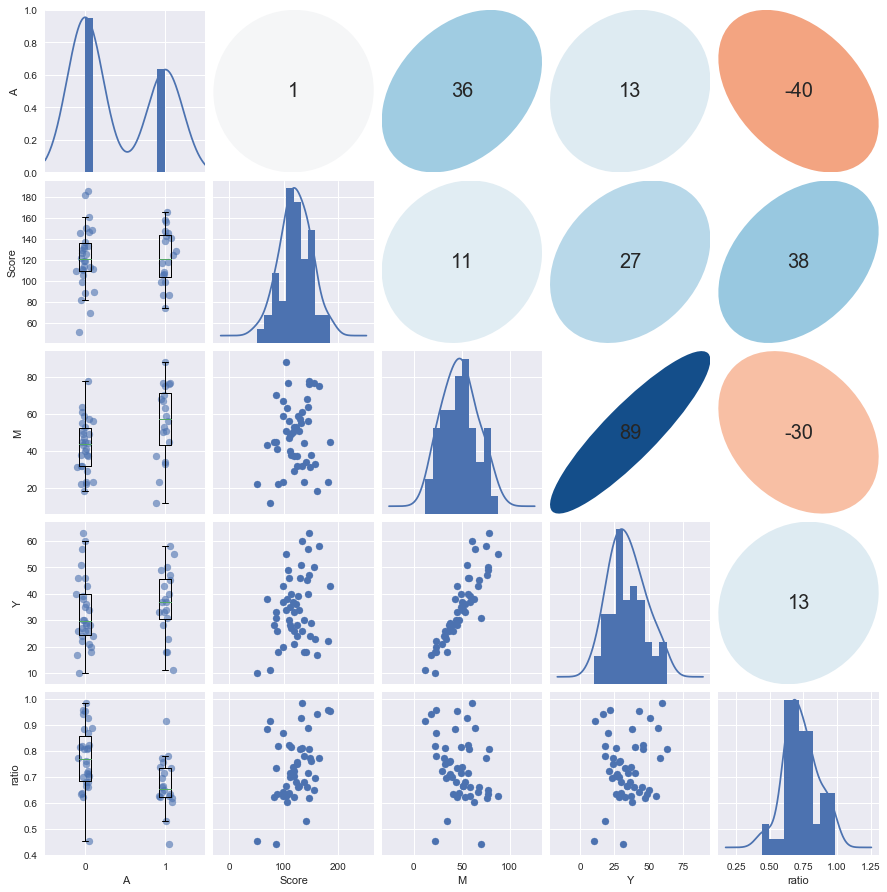

In [26]:
g = sns.PairGrid(df.iloc[:,1:], diag_sharey=False)

d = Dispatcher()
# 対角成分
g.map_diag(d.diag)
# 下三角成分
g.map_lower(d.comb);
# 上三角成分
g.map_upper(d.ellipse);
# グラフ間のスペース狭く（視認性向上のため）
g.fig.subplots_adjust(wspace=0.05, hspace=0.05)

## モデル式の記述

$q[n] = inv\_logit(\beta_1 + \beta_2 A[n] + \beta_3 Score[n] )$

$Y[n]$ ~ $Binomial( M[n], q[n] )$

## Stanでの実装

In [30]:
data

{'A': 0     0
 1     1
 2     0
 3     1
 4     1
 5     0
 6     0
 7     1
 8     0
 9     0
 10    1
 11    0
 12    1
 13    0
 14    0
 15    1
 16    0
 17    0
 18    0
 19    1
 20    1
 21    1
 22    1
 23    1
 24    1
 25    1
 26    0
 27    0
 28    0
 29    0
 30    1
 31    1
 32    1
 33    1
 34    0
 35    0
 36    1
 37    0
 38    0
 39    0
 40    0
 41    0
 42    0
 43    0
 44    0
 45    0
 46    0
 47    0
 48    0
 49    1
 Name: A, dtype: int64, 'M': 0     43
 1     56
 2     32
 3     45
 4     33
 5     61
 6     49
 7     76
 8     78
 9     64
 10    34
 11    44
 12    53
 13    40
 14    56
 15    59
 16    38
 17    45
 18    45
 19    77
 20    70
 21    77
 22    63
 23    68
 24    50
 25    51
 26    29
 27    37
 28    18
 29    49
 30    75
 31    12
 32    23
 33    37
 34    59
 35    55
 36    88
 37    47
 38    22
 39    41
 40    57
 41    32
 42    53
 43    31
 44    23
 45    51
 46    22
 47    38
 48    23
 49    67
 Name: M, dtype: 

In [31]:
model_code="""
data {
  int N;
  int<lower=0, upper=1> A[N];
  real<lower=0, upper=1> Score[N];
  int<lower=0> Y[N];
  int<lower=0> M[N];
}
parameters {
  real b1;
  real b2;
  real b3;
}
transformed parameters {
  real q[N];
  for (n in 1:N)
    q[n] = inv_logit(b1 + b2*A[n] + b3*Score[n]);
}
model {
  for (n in 1:N)
    Y[n] ~ binomial(M[n], q[n]);
}
generated quantities {
  real y_pred[N];
  for (n in 1:N)
    y_pred[n] = binomial_rng(M[n], q[n]);
}
"""

from pystan import StanModel
data = dict(N=df.shape[0], A=df.A, Score=df.Score/200, Y=df.Y, M=df.M)
sm = StanModel(model_code=model_code)

fit = sm.sampling(data=data, n_jobs=1, seed=123)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4383015d65386ef1b07759e70958e8ff NOW.


Inference for Stan model: anon_model_4383015d65386ef1b07759e70958e8ff.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1           0.09  5.9e-3   0.22  -0.34  -0.06   0.09   0.24   0.52   1370    1.0
b2          -0.62  2.0e-3   0.09   -0.8  -0.68  -0.62  -0.56  -0.44   2202    1.0
b3            1.9  9.6e-3   0.35    1.2   1.66   1.91   2.15   2.57   1361    1.0
q[0]         0.68  5.9e-4   0.02   0.63   0.66   0.68   0.69   0.72   1669    1.0
q[1]          0.7  3.2e-4   0.02   0.67   0.69    0.7   0.71   0.73   2424    1.0
q[2]         0.78  2.2e-4   0.01   0.76   0.77   0.78   0.79    0.8   2813    1.0
q[3]         0.57  5.4e-4   0.02   0.53   0.56   0.57   0.59   0.62   1671    1.0
q[4]         0.73  4.0e-4   0.02   0.69   0.71   0.73   0.74   0.76   2016    1.0
q[5]         0.79  2.3e-4   0.01   0.77   0.79    0.8    0.8   0.82   255

## traceplot

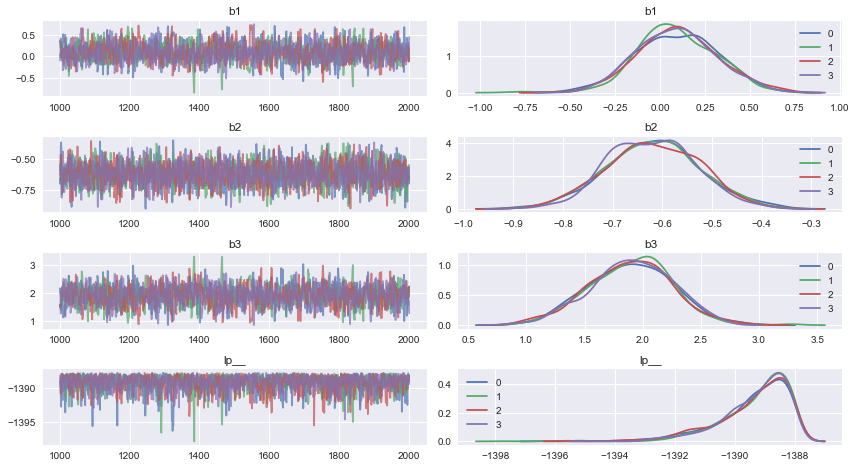

In [33]:
import math

palette = sns.color_palette()
ms = fit.extract(permuted=False, inc_warmup=True)
iter_from = fit.sim['warmup']
iter_range = np.arange(iter_from, ms.shape[0])
paraname = fit.sim['fnames_oi'][:3] #b1, b2, b3
paraname.append(fit.sim['fnames_oi'][-1]) # 'lp__' もtrace plot に追加
paraname_key = [fit.sim['fnames_oi'].index(paran) for paran in paraname]

gpp = 5 # 画像１枚あたりの縦方向のグラフ数 gpp:graph per page
num_pages = math.ceil(len(paraname)/gpp)  # parameter 数をgppで割った数より大きい最少の整数=画像枚数

for pg in range(num_pages):  # 1ページにgppx2のグラフをプロットする
    plt.figure(figsize=(12,8))
    for pos in range(gpp):
        pi = pg*gpp + pos
        if pi >= len(paraname): break
        # trace plot
        plt.subplot(gpp, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,paraname_key[pi]], color=palette[ci], label=ci, alpha=.7) for ci in range(ms.shape[1])]
        
        plt.title(paraname[pi])
        # posterior distribution 
        plt.subplot(gpp, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,paraname_key[pi]], color=palette[ci], label=ci) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.legend()

## 予測区間

In [34]:
ms = fit.extract()

qua = np.percentile(ms['y_pred'], q=[20, 50, 80], axis=0)
d_qua = pd.DataFrame(qua.T, 
                     columns=['p'+str(p) for p in [20, 50, 80]])
df_pred = df.join(d_qua)

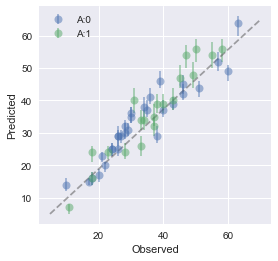

In [37]:
# 実測値と予測値の散布図
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for a, df_sub in df_pred.groupby(by='A'):
    ax.errorbar(x=df_sub.Y, y=df_sub.p50, 
                yerr=[df_sub.p50-df_sub.p20, df_sub.p80-df_sub.p50],
                fmt='o', ms=8, alpha=0.5, marker='o', label='A:'+str(a))
ax.legend()
ax.set_aspect('equal')
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.plot([5, 70], [5, 65], ls="--", c=".3", alpha=.5)

plt.show()

## 推定されたノイズの分布

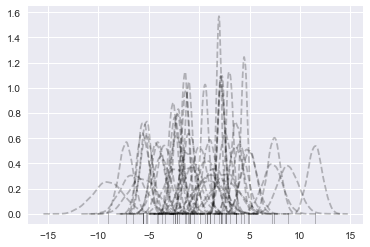

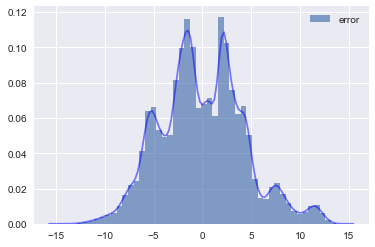

In [43]:
error = np.array(df.Y) - ms['q'] * np.array(df.M)

fig = plt.figure()
for i in range(error.shape[1]):
    sns.distplot(error[:,i], hist=False,
                kde_kws={"color": "k", "ls": "--", "alpha":1/4})
sns.distplot(error.mean(axis=0), hist=False, kde=False, rug=True, 
             rug_kws={"color":"k", "alpha":1/4})
plt.show()

fig = plt.figure()
sns.distplot(error.flatten(),
             hist_kws={"alpha":2/3},
             kde_kws={"color": "b", "ls": "-", "alpha":1/2},
             label='error')
#sns.distplot(np.random.normal(0, np.mean(ms['sigma']), 100000),
#             kde_kws={"color": "k", "ls": "--", "alpha":1/2},
#             hist=False, label='Normal Dist.')
plt.legend()
plt.show()

## MCMC の散布図行列

In [44]:
df_mcmc = pd.DataFrame({'b1':ms['b1'], 
                      'b2':ms['b2'], 
                      'b3':ms['b3'],
                      'q1':ms['q'][:,0],
                      'q50':ms['q'][:,49],
                      'lp__':ms['lp__']},
                      columns=['b1','b2','b3', 'q1', 'q50', 'lp__'])

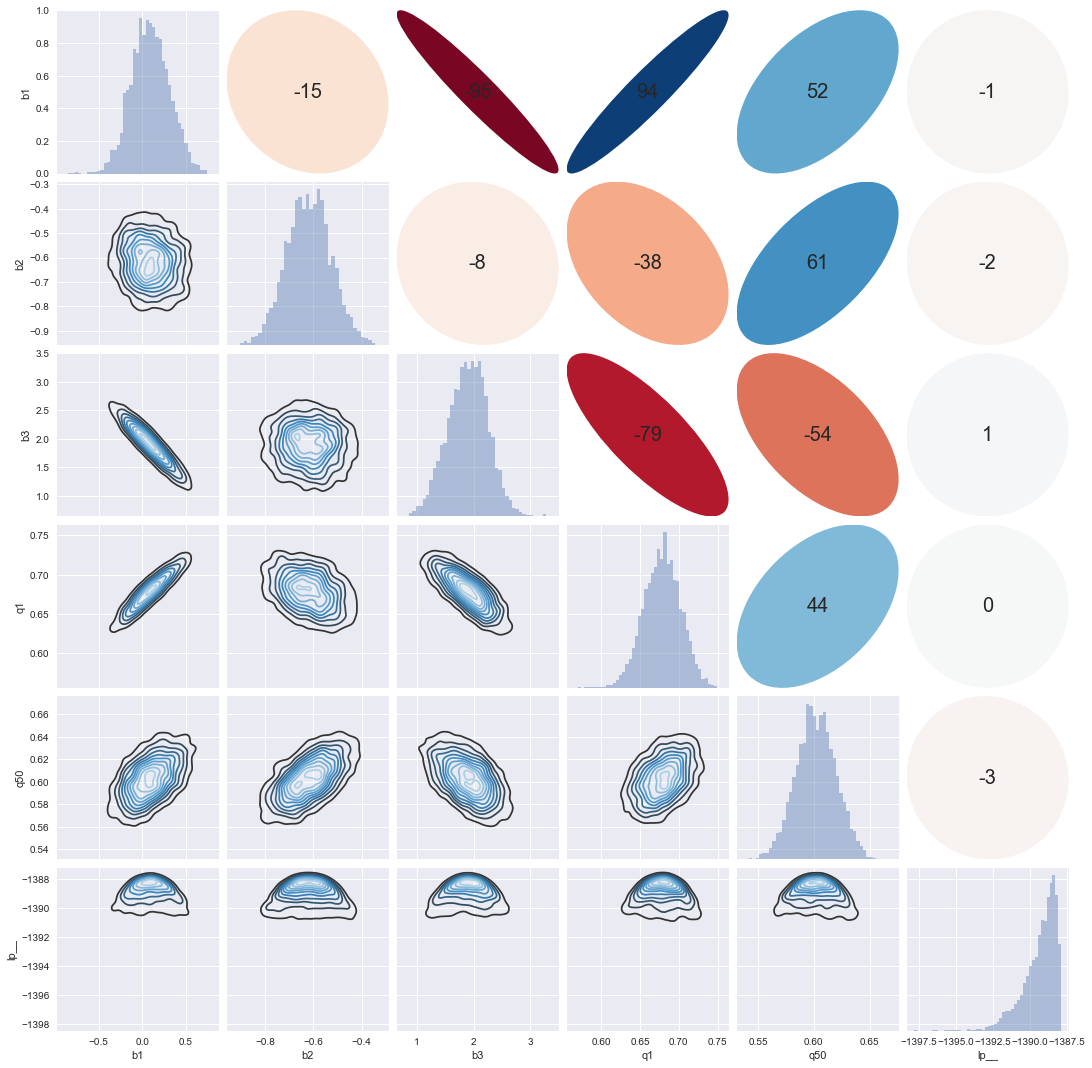

In [46]:
sns.set(font_scale=1)
g = sns.PairGrid(df_mcmc, diag_sharey=False)
d = Dispatcher()
# 対角成分
g.map_diag(sns.distplot, kde=False)
# 下三角成分
g.map_lower(sns.kdeplot, cmap='Blues_d');
# 上三角成分
g.map_upper(d.ellipse);

g.fig.subplots_adjust(wspace=0.05, hspace=0.05)